### 事前準備
```
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README
```

### 【問題1】BoWのスクラッチ実装

In [3]:
import numpy as np
import pandas as pd

# データセット
first = "This movie is SOOOO funny!!!".lower().replace('!', '').split()
second = "What a movie! I never".lower().replace('!', '').split()
third = "best movie ever!!!!! this movie".lower().replace('!', '').split()
sum_text = first + second + third

uq_sum_text = set(sum_text)
results = np.zeros((3, len(uq_sum_text)))
column_idxes = {u:i for i, u in enumerate(uq_sum_text)}
for i, line in enumerate([first, second, third]):
    for word in line:
        # その行でその単語が出現する回数
        num = line.count(word)
        word_idx = column_idxes[word]
        results[i][word_idx] = num
print(column_idxes)
print(results)


{'what': 0, 'movie': 1, 'funny': 2, 'this': 3, 'i': 4, 'soooo': 5, 'is': 6, 'never': 7, 'a': 8, 'ever': 9, 'best': 10}
[[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 2. 0. 1. 0. 0. 0. 0. 0. 1. 1.]]


### 【問題2】TF-IDFの計算

In [11]:
# データ準備
from sklearn.datasets import load_files
import numpy as np
train_review = load_files('../data/aclImdb/train/', encoding='utf-8')
x_train, y_train = np.array(train_review.data), np.array(train_review.target)
test_review = load_files('../data/aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
vec = TfidfVectorizer(stop_words=stop_words, max_features=5000, norm=None)
x_train2 = vec.fit_transform(x_train)
x_test2 = vec.fit_transform(x_test)
print(x_train2.shape)
print(x_test2.shape)

(25000, 5000)
(25000, 5000)


In [13]:
### 【問題3】TF-IDFを用いた学習

In [14]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier().fit(x_train2, y_train)
y_pred = lgb.predict(x_test2)
print(y_pred)
print(lgb.score(x_test2, y_test))

[1 0 0 ... 1 0 1]
0.55048


In [15]:
### 【問題4】TF-IDFのスクラッチ実装

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.0464534   0.02904869 -0.00028768 -0.03070964 -0.00207491  0.00311279
  0.04373253 -0.04462465  0.01634402 -0.04851749]
movieのベクトル : 
[-0.01774741  0.01298378  0.02915793 -0.04922174 -0.01409742  0.04511788
 -0.03220137 -0.03196328 -0.03866027  0.01426562]
isのベクトル : 
[ 0.00109121 -0.03973011  0.04586015  0.03566549  0.03287235  0.02982856
 -0.0290995   0.03217437  0.03525032  0.00069868]
veryのベクトル : 
[-0.04197066 -0.04910351 -0.04641383 -0.03596898 -0.00256921  0.00428712
  0.00646759 -0.01724635 -0.026315    0.00454275]
goodのベクトル : 
[ 0.01410716 -0.01913979  0.0318657  -0.00788754  0.01945338  0.04860158
 -0.00265215 -0.03234165 -0.02420672 -0.00882292]
filmのベクトル : 
[-0.03898276 -0.02019741  0.03827958 -0.01539082 -0.00244779  0.04541972
  0.03905338 -0.0360239  -0.04667769 -0.03024385]
aのベクトル : 
[-0.03327415  0.01062959 -0.01330947 -0.02425268  0.02975043 -0.01050549
  0.01862607  0.0347565

<ipython-input-16-b2117e9a24a6>:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
<ipython-input-16-b2117e9a24a6>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_tsne = tsne_model.fit_transform(model[vocabs])


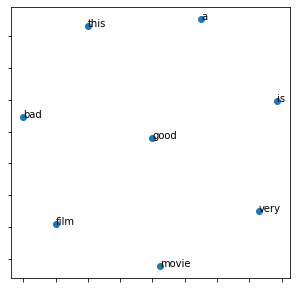

In [16]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

# 単語の距離
model.wv.most_similar(positive="good", topn=3)

# 可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [ ]:
### 【問題5】コーパスの前処理

In [37]:
import re
# URLの除去
tmp_list = []
for r in x_train:
    # テキストクリーニング: url除去
    record = re.sub(r"(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+$,%#]+)", "" , r)
    # テキストクリーニング: 余計な記号などを排除
    record = re.sub('[^a-zA-Z]', ' ', record)
    # テキストクリーニング: 大文字を小文字に変換
    record = record.lower()
    tmp_list.append(np.array(record.split()))

x_train3 = np.array(tmp_list)

<ipython-input-37-01012ea7bdbd>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train3 = np.array(tmp_list)


In [ ]:
### 【問題6】Word2Vecの学習

In [40]:
model = Word2Vec(min_count=1, size=10)
model.build_vocab(x_train3)
model.train(x_train3, total_examples=model.corpus_count, epochs=model.iter)

### その他

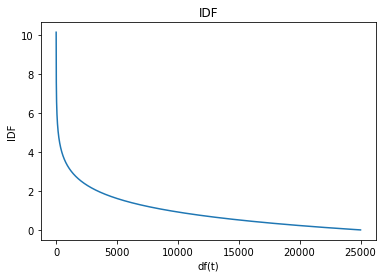

In [41]:
# idf
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [42]:
# はじめて使う場合はストップワードをダウンロード
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords') # ~/ に nltk_data としてダウンロードされる
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [43]:
# vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
# bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
# df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
# display(df)